# Temporal-Difference Methods

In this notebook, you will write your own implementations of many Temporal-Difference (TD) methods.

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

---

### Part 0: Explore CliffWalkingEnv

We begin by importing the necessary packages.

In [1]:
%config Completer.use_jedi = False

In [2]:
import sys
import gym
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline

import check_test
from plot_utils import plot_values

Use the code cell below to create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment.

In [3]:
env = gym.make('CliffWalking-v0')

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [4]:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(48)


In this mini-project, we will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.  Please take the time now to make sure that you understand _why_ this is the optimal state-value function.

_**Note**: You can safely ignore the values of the cliff "states" as these are not true states from which the agent can make decisions.  For the cliff "states", the state-value function is not well-defined._

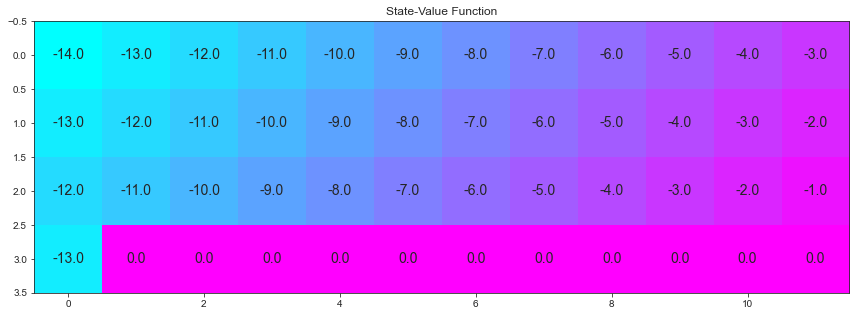

In [5]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

### Part 1: TD Control: Sarsa

In this section, you will write your own implementation of the Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [6]:
import random

In [7]:
def update_policy(state,Q,policy):
    k=max(Q[state]) #maximum value
    indices=[j for j in range(len(Q[state])) if  Q[state][j] == k] #Get all indices where the Q[index]= maximum value
    policy[state]=np.random.choice(indices) if len(indices)>1 else indices[0]

In [8]:
def get_action(state, policy,epsilon):
    if state in policy and random.random()>epsilon:
        return policy[state]
    else:
        return random.choice(np.arange(env.action_space.n))

In [9]:
def get_sarsa(state, action, next_state,next_value,alpha, gamma,Q,reward,done):
    if not done:
        q= Q[state][action]+alpha*(reward+gamma*(Q[next_state][next_value])-Q[state][action])
    else:
        q= Q[state][action]+alpha*(reward+gamma*0-Q[state][action])
    return q

In [10]:
def sarsa(env, num_episodes, alpha, gamma=0.9,epsilon=5,drop=0.995,epsilon_min=0.005): #drop of 0.985 gives perfect results for 1st 2 rows
    # initialize action-value function (empty dictionary of arrays)
    Q=defaultdict(lambda: np.zeros(env.action_space.n))
    policy=defaultdict(lambda: 0)
    # initialize performance monitor
    J=[]
    j=0
    for i in range(num_episodes):
        states=[]
        state=env.reset()
        action=get_action(state,policy, epsilon)
        if i%100==0:
            print("\rEpisode {}/{}".format(i, num_episodes), end="")
            sys.stdout.flush()
        while True: # for each timestep of the episode
            next_state,reward,done,info=env.step(action)
            next_action=get_action(next_state,policy, epsilon)
            Q[state][action]=get_sarsa(state, action, next_state, next_action,alpha, gamma,Q,reward,done)
            update_policy(state,Q,policy)
            if done:              
                break
            else:
                state=next_state
                action=next_action
        epsilon=1/(i+1)
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 4900/5000

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 2  2  1  1  1  1  1  0  1  0  0  2]
 [ 1  0  2  1  1  1  1  1  1  2  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


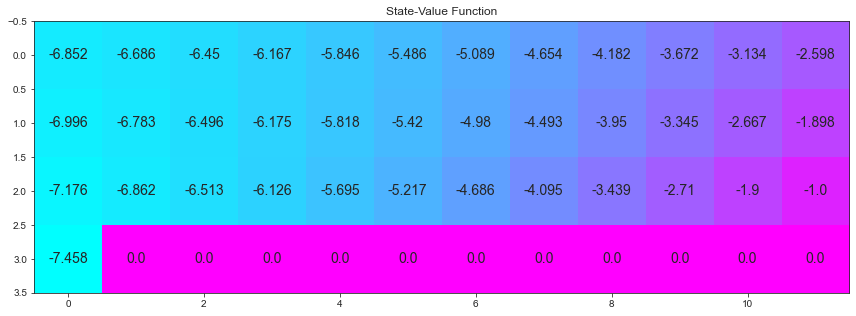

In [11]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = sarsa(env, 5000, .01)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

<b> Key highlights: </b> <br>
    You have to be very careful about epsilon:<br>
    <ul>
     <li>I used a max(epsilon*drop,epsilon_min) which exponentially drops epsilon and throws an error since the model starts exploiting super fast </li>
     <li>I tried 1/(i+1) but even that exponentially dropped epsilon and again the exponential reduction in epsilon forced exploting too early </li>
     <li>Finally, a drop of 1/(i+0.3) was adequate to reduce epsilon gradually enough

### Part 2: TD Control: Q-learning

In this section, you will write your own implementation of the Q-learning control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [12]:
def get_q_learning(state, action, next_state, reward, alpha, gamma, done,Q):
    if done:
        q= Q[state][action]+alpha*(reward+ 0 - Q[state][action])        
    else:
        q = Q[state][action]+alpha*(reward+gamma*max(Q[next_state]) - Q[state][action])
    return q

In [13]:
def q_learning(env, num_episodes, alpha, gamma=1.0,epsilon=1):
    Q=defaultdict(lambda:np.zeros(env.action_space.n))
    policy=defaultdict(lambda:0)
    for i in range(num_episodes):
        state=env.reset()
        action=get_action(state, policy,epsilon)
        if i%100==0:
            print("\rEpisode {}/{}".format(i, num_episodes), end="")
            sys.stdout.flush()
        epsilon=1/(0.6+i)
        while True:
            next_state, reward, done, info = env.step(action)
            Q[state][action]=get_q_learning(state, action, next_state, reward, alpha, gamma, done,Q)
            update_policy(state,Q,policy)
            if done:
                break
            else:
                next_action=get_action(next_state, policy,epsilon)
                state=next_state
                action=next_action
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function. 

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 4900/5000

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 0  1  1  0  1  1  0  1  2  1  1  0]
 [ 3  1  0  1  2  1  2  1  1  2  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


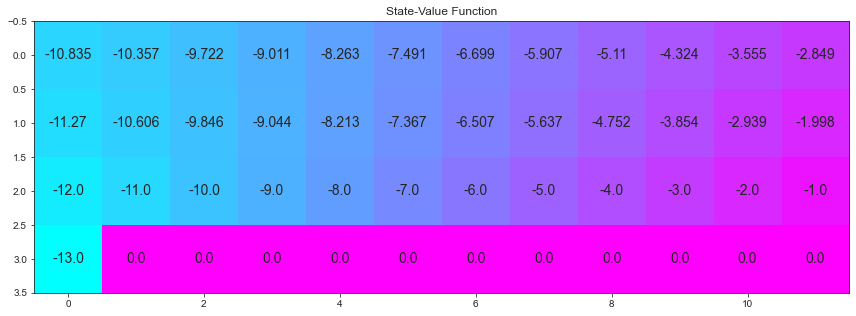

In [14]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = q_learning(env, 5000, .01)
# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
check_test.run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

### Part 3: TD Control: Expected Sarsa

In this section, you will write your own implementation of the Expected Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [15]:
def get_expected_sarsa(state, action, reward, next_state, Q ,done, alpha, gamma,epsilon):
    if done:
        q=Q[state][action]+alpha*(reward+0-Q[state][action])
    else:
        max_val = max(Q[next_state])*(1-epsilon+(epsilon/len(Q[state]))) #Weight the largest value with 1-e+e/|A|
        vals=np.sum(Q[next_state])*epsilon/len(Q[next_state]) + max_val  #Weight all the values by e/|A| and add them to weighted max value to return expected value
        q=Q[state][action]+alpha*(reward+gamma*vals-Q[state][action]) #get the updated value for Q[state][action] and return
    return q

In [16]:
def expected_sarsa(env, num_episodes, alpha, gamma=1.0):
    # initialize action-value function (empty dictionary of arrays)
    Q=defaultdict(lambda: np.zeros(env.action_space.n))
    policy={}
    # initialize performance monitor
    for i in range(num_episodes):
        epsilon=0.005
        states=[] #Troubleshooting
        state=env.reset()
        if state in policy:
            action=get_action(state,policy, epsilon)
        else:
            action=env.action_space.sample()    
        while True: # for each timestep of the episode
            next_state,reward,done,info=env.step(action)
            next_action = get_action(next_state, policy,epsilon) if next_state in policy.keys() else env.action_space.sample()
            Q[state][action]=get_expected_sarsa(state, action, reward, next_state, Q, done, alpha, gamma,epsilon)
            update_policy(state,Q,policy)
            states.append((state,action,reward,next_state))
            if done:
                break
            else:
                state=next_state
                action=next_action
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  2  1  1  1  1  0  1  2  1  3]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


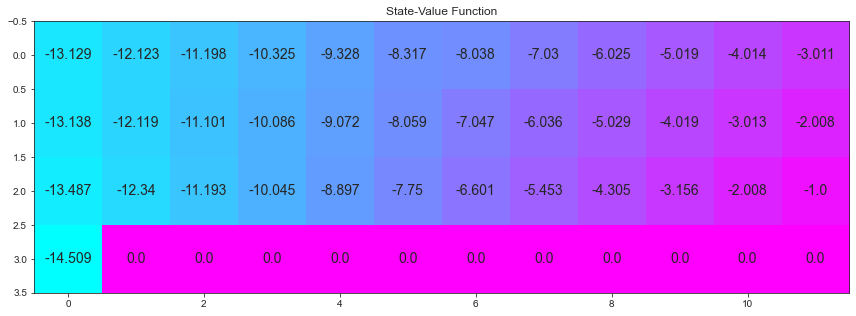

In [17]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = expected_sarsa(env, 10000, 1)
# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])